<a href="https://colab.research.google.com/github/rajy4683/EVAP2/blob/master/EVA4P2S11_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sun Nov  1 10:40:52 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#!pip install torch numpy matplotlib sacrebleu

In [2]:
!pip install sacrebleu


     |████████████████████████████████| 71kB 2.2MB/s 


In [3]:
!pip install torch==1.5.0+cu92 torchvision==0.6.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html


Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 603.7MB 31kB/s 
     |████████████████████████████████| 6.5MB 2.1MB/s 
  Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101
  Found existing installation: torchvision 0.7.0+cu101
    Uninstalling torchvision-0.7.0+cu101:
      Successfully uninstalled torchvision-0.7.0+cu101


In [4]:
!pip install boto3
!pip install git+git://github.com/pytorch/text spacy 
!python -m spacy download en
!python -m spacy download de

     |████████████████████████████████| 133kB 2.8MB/s 
     |████████████████████████████████| 71kB 6.1MB/s 
     |████████████████████████████████| 6.7MB 8.3MB/s 
     |████████████████████████████████| 133kB 43.0MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Cloning git://github.com/pytorch/text to /tmp/pip-req-build-meqqtqkv
  Running command git clone -q git://github.com/pytorch/text /tmp/pip-req-build-meqqtqkv
  Running command git submodule update --init --recursive -q
  Created wheel for torchtext: filename=torchtext-0.9.0a0+97e6d1d-cp36-cp36m-linux_x86_64.whl size=7204252 sha256=5d2f17c79beb6e8e232509b2eeb4102ef101e04b9f18276abe96e6093b1190d8
  Stored in directory: /tmp/pip-ephem-wheel-cache-9apwmnuf/wheels/39/42/ff/82f5ccbb0f30b25e14610376f5d0c67913fc05017dab59f8eb
Successfully built t

In [5]:
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from IPython.core.debugger import set_trace
import sacrebleu
import os
import sys
import io
import glob
import boto3
# we will use CUDA if it is available
USE_CUDA = torch.cuda.is_available()
DEVICE=torch.device('cuda:0') # or set to 'cpu'
print("CUDA:", USE_CUDA)
print(DEVICE)

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

CUDA: True
cuda:0


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
sys.path.append("/content/drive/My Drive/EVA4/RekogNizer")
sys.path.append("/content/drive/My Drive/EVA4/")

## Full Model

Here we define a function from hyperparameters to a full model. 

In [8]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many 
    other models.
    """
    def __init__(self, encoder, decoder, src_embed, trg_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.trg_embed = trg_embed
        self.generator = generator
        
    def forward(self, src, trg, src_mask, trg_mask, src_lengths, trg_lengths):
        """Take in and process masked src and target sequences."""
        encoder_hidden, encoder_final = self.encode(src, src_mask, src_lengths)
        return self.decode(encoder_hidden, encoder_final, src_mask, trg, trg_mask)
    
    def encode(self, src, src_mask, src_lengths):
        return self.encoder(self.src_embed(src), src_mask, src_lengths)
    
    def decode(self, encoder_hidden, encoder_final, src_mask, trg, trg_mask,
               decoder_hidden=None):
        return self.decoder(self.trg_embed(trg), encoder_hidden, encoder_final,
                            src_mask, trg_mask, hidden=decoder_hidden)

In [9]:
class Generator(nn.Module):
    """Define standard linear + softmax generation step."""
    def __init__(self, hidden_size, vocab_size):
        super(Generator, self).__init__()
        self.proj = nn.Linear(hidden_size, vocab_size, bias=False)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

In [10]:
class Encoder(nn.Module):
    """Encodes a sequence of word embeddings"""
    def __init__(self, input_size, hidden_size, num_layers=1, dropout=0.):
        super(Encoder, self).__init__()
        self.num_layers = num_layers
        self.rnn = nn.GRU(input_size, hidden_size, num_layers, 
                          batch_first=True, bidirectional=True, dropout=dropout)
        
    def forward(self, x, mask, lengths):
        """
        Applies a bidirectional GRU to sequence of embeddings x.
        The input mini-batch x needs to be sorted by length.
        x should have dimensions [batch, time, dim].
        """
        packed = pack_padded_sequence(x, lengths, batch_first=True)
        output, final = self.rnn(packed)
        output, _ = pad_packed_sequence(output, batch_first=True)

        # we need to manually concatenate the final states for both directions
        fwd_final = final[0:final.size(0):2]
        bwd_final = final[1:final.size(0):2]
        final = torch.cat([fwd_final, bwd_final], dim=2)  # [num_layers, batch, 2*dim]

        return output, final

In [11]:
class Decoder(nn.Module):
    """A conditional RNN decoder with attention."""
    
    def __init__(self, emb_size, hidden_size, attention, num_layers=1, dropout=0.5,
                 bridge=True):
        super(Decoder, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.attention = attention
        self.dropout = dropout
                 
        self.rnn = nn.GRU(emb_size + 2*hidden_size, hidden_size, num_layers,
                          batch_first=True, dropout=dropout)
                 
        # to initialize from the final encoder state
        self.bridge = nn.Linear(2*hidden_size, hidden_size, bias=True) if bridge else None

        self.dropout_layer = nn.Dropout(p=dropout)
        self.pre_output_layer = nn.Linear(hidden_size + 2*hidden_size + emb_size,
                                          hidden_size, bias=False)
        
    def forward_step(self, prev_embed, encoder_hidden, src_mask, proj_key, hidden):
        """Perform a single decoder step (1 word)"""

        # compute context vector using attention mechanism
        query = hidden[-1].unsqueeze(1)  # [#layers, B, D] -> [B, 1, D]
        context, attn_probs = self.attention(
            query=query, proj_key=proj_key,
            value=encoder_hidden, mask=src_mask)

        # update rnn hidden state
        rnn_input = torch.cat([prev_embed, context], dim=2)
        output, hidden = self.rnn(rnn_input, hidden)
        
        pre_output = torch.cat([prev_embed, output, context], dim=2)
        pre_output = self.dropout_layer(pre_output)
        pre_output = self.pre_output_layer(pre_output)

        return output, hidden, pre_output
    
    def forward(self, trg_embed, encoder_hidden, encoder_final, 
                src_mask, trg_mask, hidden=None, max_len=None):
        """Unroll the decoder one step at a time."""
                                         
        # the maximum number of steps to unroll the RNN
        if max_len is None:
            max_len = trg_mask.size(-1)

        # initialize decoder hidden state
        if hidden is None:
            hidden = self.init_hidden(encoder_final)
        
        # pre-compute projected encoder hidden states
        # (the "keys" for the attention mechanism)
        # this is only done for efficiency
        proj_key = self.attention.key_layer(encoder_hidden)
        
        # here we store all intermediate hidden states and pre-output vectors
        decoder_states = []
        pre_output_vectors = []
        
        # unroll the decoder RNN for max_len steps
        for i in range(max_len):
            prev_embed = trg_embed[:, i].unsqueeze(1)
            output, hidden, pre_output = self.forward_step(
              prev_embed, encoder_hidden, src_mask, proj_key, hidden)
            decoder_states.append(output)
            pre_output_vectors.append(pre_output)

        decoder_states = torch.cat(decoder_states, dim=1)
        pre_output_vectors = torch.cat(pre_output_vectors, dim=1)
        return decoder_states, hidden, pre_output_vectors  # [B, N, D]

    def init_hidden(self, encoder_final):
        """Returns the initial decoder state,
        conditioned on the final encoder state."""

        if encoder_final is None:
            return None  # start with zeros

        return torch.tanh(self.bridge(encoder_final))            


In [12]:
class BahdanauAttention(nn.Module):
    """Implements Bahdanau (MLP) attention"""
    
    def __init__(self, hidden_size, key_size=None, query_size=None):
        super(BahdanauAttention, self).__init__()
        
        # We assume a bi-directional encoder so key_size is 2*hidden_size
        key_size = 2 * hidden_size if key_size is None else key_size
        query_size = hidden_size if query_size is None else query_size


        self.key_layer = nn.Linear(key_size, hidden_size, bias=False)
        self.query_layer = nn.Linear(query_size, hidden_size, bias=False)
        self.energy_layer = nn.Linear(hidden_size, 1, bias=False)
        
        # to store attention scores
        self.alphas = None
        
    def forward(self, query=None, proj_key=None, value=None, mask=None):
        assert mask is not None, "mask is required"

        # We first project the query (the decoder state).
        # The projected keys (the encoder states) were already pre-computated.
        query = self.query_layer(query)
        
        # Calculate scores.
        scores = self.energy_layer(torch.tanh(query + proj_key))
        scores = scores.squeeze(2).unsqueeze(1)
        
        # Mask out invalid positions.
        # The mask marks valid positions so we invert it using `mask & 0`.
        scores.data.masked_fill_(mask == 0, -float('inf'))
        
        # Turn scores to probabilities.
        alphas = F.softmax(scores, dim=-1)
        self.alphas = alphas        
        
        # The context vector is the weighted sum of the values.
        context = torch.bmm(alphas, value)
        
        # context shape: [B, 1, 2D], alphas shape: [B, 1, M]
        return context, alphas

In [13]:
def make_model(src_vocab, tgt_vocab, emb_size=256, hidden_size=512, num_layers=1, dropout=0.1):
    "Helper: Construct a model from hyperparameters."

    attention = BahdanauAttention(hidden_size)

    model = EncoderDecoder(
        Encoder(emb_size, hidden_size, num_layers=num_layers, dropout=dropout),
        Decoder(emb_size, hidden_size, attention, num_layers=num_layers, dropout=dropout),
        nn.Embedding(src_vocab, emb_size),
        nn.Embedding(tgt_vocab, emb_size),
        Generator(hidden_size, tgt_vocab))

    return model.cuda() if USE_CUDA else model

# Training

This section describes the training regime for our models.

We stop for a quick interlude to introduce some of the tools 
needed to train a standard encoder decoder model. First we define a batch object that holds the src and target sentences for training, as well as their lengths and masks. 

## Batches and Masking

In [14]:
class Batch:
    """Object for holding a batch of data with mask during training.
    Input is a batch from a torch text iterator.
    """
    def __init__(self, src, trg, pad_index=0):
        
        src, src_lengths = src
        
        self.src = src
        self.src_lengths = src_lengths
        self.src_mask = (src != pad_index).unsqueeze(-2)
        self.nseqs = src.size(0)
        
        self.trg = None
        self.trg_y = None
        self.trg_mask = None
        self.trg_lengths = None
        self.ntokens = None

        if trg is not None:
            trg, trg_lengths = trg
            self.trg = trg[:, :-1]
            self.trg_lengths = trg_lengths
            self.trg_y = trg[:, 1:]
            self.trg_mask = (self.trg_y != pad_index)
            self.ntokens = (self.trg_y != pad_index).data.sum().item()
        
        if USE_CUDA:
            self.src = self.src.cuda()
            self.src_mask = self.src_mask.cuda()

            if trg is not None:
                self.trg = self.trg.cuda()
                self.trg_y = self.trg_y.cuda()
                self.trg_mask = self.trg_mask.cuda()
                

## Training Loop
The code below trains the model for 1 epoch (=1 pass through the training data).

In [15]:
def run_epoch(data_iter, model, loss_compute, print_every=50):
    """Standard Training and Logging Function"""

    start = time.time()
    total_tokens = 0
    total_loss = 0
    print_tokens = 0

    for i, batch in enumerate(data_iter, 1):
        
        out, _, pre_output = model.forward(batch.src, batch.trg,
                                           batch.src_mask, batch.trg_mask,
                                           batch.src_lengths, batch.trg_lengths)
        loss = loss_compute(pre_output, batch.trg_y, batch.nseqs)
        total_loss += loss
        total_tokens += batch.ntokens
        print_tokens += batch.ntokens
        
        if model.training and i % print_every == 0:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
                    (i, loss / batch.nseqs, print_tokens / elapsed))
            start = time.time()
            print_tokens = 0

    return math.exp(total_loss / float(total_tokens))
def data_gen(num_words=11, batch_size=16, num_batches=100, length=10, pad_index=0, sos_index=1):
    """Generate random data for a src-tgt copy task."""
    for i in range(num_batches):
        data = torch.from_numpy(
          np.random.randint(1, num_words, size=(batch_size, length)))
        data[:, 0] = sos_index
        data = data.cuda() if USE_CUDA else data
        src = data[:, 1:]
        trg = data
        src_lengths = [length-1] * batch_size
        trg_lengths = [length] * batch_size
        yield Batch((src, src_lengths), (trg, trg_lengths), pad_index=pad_index)
class SimpleLossCompute:
    """A simple loss compute and train function."""

    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt

    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)),
                              y.contiguous().view(-1))
        loss = loss / norm

        if self.opt is not None:
            loss.backward()          
            self.opt.step()
            self.opt.zero_grad()

        return loss.data.item() * norm

## Optimizer

We will use the [Adam optimizer](https://arxiv.org/abs/1412.6980) with default settings ($\beta_1=0.9$, $\beta_2=0.999$ and $\epsilon=10^{-8}$).

We will use $0.0003$ as the learning rate here, but for different problems another learning rate may be more appropriate. You will have to tune that.

In [ ]:
torch.load("/content/attention_s11_new.pth")

In [16]:
def plot_perplexity(perplexities):
    """plot perplexities"""
    plt.title("Perplexity per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Perplexity")
    plt.plot(perplexities)

def greedy_decode(model, src, src_mask, src_lengths, max_len=100, sos_index=1, eos_index=None):
    """Greedily decode a sentence."""

    with torch.no_grad():
        encoder_hidden, encoder_final = model.encode(src, src_mask, src_lengths)
        prev_y = torch.ones(1, 1).fill_(sos_index).type_as(src)
        trg_mask = torch.ones_like(prev_y)

    output = []
    attention_scores = []
    hidden = None

    for i in range(max_len):
        with torch.no_grad():
            out, hidden, pre_output = model.decode(
              encoder_hidden, encoder_final, src_mask,
              prev_y, trg_mask, hidden)

            # we predict from the pre-output layer, which is
            # a combination of Decoder state, prev emb, and context
            prob = model.generator(pre_output[:, -1])

        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.data.item()
        output.append(next_word)
        prev_y = torch.ones(1, 1).type_as(src).fill_(next_word)
        attention_scores.append(model.decoder.attention.alphas.cpu().numpy())
    
    output = np.array(output)
        
    # cut off everything starting from </s> 
    # (only when eos_index provided)
    if eos_index is not None:
        first_eos = np.where(output==eos_index)[0]
        if len(first_eos) > 0:
            output = output[:first_eos[0]]      
    
    return output, np.concatenate(attention_scores, axis=1)
  

def lookup_words(x, vocab=None):
    if vocab is not None:
        x = [vocab.itos[i] for i in x]

    return [str(t) for t in x]

In [17]:
def print_examples(example_iter, model, n=2, max_len=100, 
                   sos_index=1, 
                   src_eos_index=None, 
                   trg_eos_index=None, 
                   src_vocab=None, trg_vocab=None):
    """Prints N examples. Assumes batch size of 1."""

    model.eval()
    count = 0
    print()
    
    if src_vocab is not None and trg_vocab is not None:
        src_eos_index = src_vocab.stoi[EOS_TOKEN]
        trg_sos_index = trg_vocab.stoi[SOS_TOKEN]
        trg_eos_index = trg_vocab.stoi[EOS_TOKEN]
    else:
        src_eos_index = None
        trg_sos_index = 1
        trg_eos_index = None
        
    for i, batch in enumerate(example_iter):
      
        src = batch.src.cpu().numpy()[0, :]
        trg = batch.trg_y.cpu().numpy()[0, :]

        # remove </s> (if it is there)
        src = src[:-1] if src[-1] == src_eos_index else src
        trg = trg[:-1] if trg[-1] == trg_eos_index else trg      
      
        result, _ = greedy_decode(
          model, batch.src, batch.src_mask, batch.src_lengths,
          max_len=max_len, sos_index=trg_sos_index, eos_index=trg_eos_index)
        print("Example #%d" % (i+1))
        print("Src : ", " ".join(lookup_words(src, vocab=src_vocab)))
        print("Trg : ", " ".join(lookup_words(trg, vocab=trg_vocab)))
        print("Pred: ", " ".join(lookup_words(result, vocab=trg_vocab)))
        print()
        
        count += 1
        if count == n:
            break

## Training the copy task

In [ ]:
def train_copy_task():
    """Train the simple copy task."""
    num_words = 11
    criterion = nn.NLLLoss(reduction="sum", ignore_index=0)
    model = make_model(num_words, num_words, emb_size=32, hidden_size=64)
    optim = torch.optim.Adam(model.parameters(), lr=0.0003)
    eval_data = list(data_gen(num_words=num_words, batch_size=1, num_batches=100))
 
    dev_perplexities = []
    
    if USE_CUDA:
        model.cuda()

    for epoch in range(10):
        
        print("Epoch %d" % epoch)

        # train
        model.train()
        data = data_gen(num_words=num_words, batch_size=32, num_batches=100)
        run_epoch(data, model,
                  SimpleLossCompute(model.generator, criterion, optim))

        # evaluate
        model.eval()
        with torch.no_grad(): 
            perplexity = run_epoch(eval_data, model,
                                   SimpleLossCompute(model.generator, criterion, None))
            print("Evaluation perplexity: %f" % perplexity)
            dev_perplexities.append(perplexity)
            print_examples(eval_data, model, n=2, max_len=9)
        
    return dev_perplexities

In [ ]:
# train the copy task
dev_perplexities = train_copy_task()


    
plot_perplexity(dev_perplexities)

You can see that the model managed to correctly 'translate' the two examples in the end.

Moreover, the perplexity of the development data nicely went down towards 1.

# A Real World Example

Now we consider a real-world example using the IWSLT German-English Translation task. 
This task is much smaller than usual, but it illustrates the whole system. 

The cell below installs torch text and spacy. This might take a while.

In [18]:
# For data loading.
from torchtext import data, datasets

if True:
    import spacy
    spacy_de = spacy.load('de')
    spacy_en = spacy.load('en')

    def tokenize_de(text):
        return [tok.text for tok in spacy_de.tokenizer(text)]

    def tokenize_en(text):
        return [tok.text for tok in spacy_en.tokenizer(text)]

    UNK_TOKEN = "<unk>"
    PAD_TOKEN = "<pad>"    
    SOS_TOKEN = "<s>"
    EOS_TOKEN = "</s>"
    LOWER = True
    
    # we include lengths to provide to the RNNs
    SRC = data.Field(tokenize=tokenize_de, 
                     batch_first=True, lower=LOWER, include_lengths=True,
                     unk_token=UNK_TOKEN, pad_token=PAD_TOKEN, init_token=None, eos_token=EOS_TOKEN)
    TRG = data.Field(tokenize=tokenize_en, 
                     batch_first=True, lower=LOWER, include_lengths=True,
                     unk_token=UNK_TOKEN, pad_token=PAD_TOKEN, init_token=SOS_TOKEN, eos_token=EOS_TOKEN)

    MAX_LEN = 25  # NOTE: we filter out a lot of sentences for speed
    train_data, valid_data, test_data = datasets.IWSLT.splits(
        exts=('.de', '.en'), fields=(SRC, TRG), 
        filter_pred=lambda x: len(vars(x)['src']) <= MAX_LEN and 
            len(vars(x)['trg']) <= MAX_LEN)
    MIN_FREQ = 5  # NOTE: we limit the vocabulary to frequent words for speed
    SRC.build_vocab(train_data.src, min_freq=MIN_FREQ)
    TRG.build_vocab(train_data.trg, min_freq=MIN_FREQ)
    
    PAD_INDEX = TRG.vocab.stoi[PAD_TOKEN]


/usr/local/lib/python3.6/dist-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


downloading de-en.tgz


de-en.tgz: 100%|██████████| 24.2M/24.2M [00:04<00:00, 5.43MB/s]


.data/iwslt/de-en/IWSLT16.TED.tst2010.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TED.tst2014.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TED.tst2011.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TEDX.dev2012.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TED.tst2010.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TED.tst2014.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TEDX.tst2014.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TEDX.tst2013.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TED.tst2011.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TED.dev2010.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TED.tst2012.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TED.tst2013.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TEDX.tst2014.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TED.dev2010.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TED.tst2013.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TEDX.dev2012.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TED.tst2012.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TEDX.tst2013.de-en.de.xml
.data/iwslt/de-en/train.tags.de-en.en
.data/iwslt/de-en/train.tags.de-en.de


/usr/local/lib/python3.6/dist-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)


In [19]:
def print_data_info(train_data, valid_data, test_data, src_field, trg_field):
    """ This prints some useful stuff about our data sets. """

    print("Data set sizes (number of sentence pairs):")
    print('train', len(train_data))
    print('valid', len(valid_data))
    print('test', len(test_data), "\n")

    print("First training example:")
    print("src:", " ".join(vars(train_data[0])['src']))
    print("trg:", " ".join(vars(train_data[0])['trg']), "\n")

    print("Most common words (src):")
    print("\n".join(["%10s %10d" % x for x in src_field.vocab.freqs.most_common(10)]), "\n")
    print("Most common words (trg):")
    print("\n".join(["%10s %10d" % x for x in trg_field.vocab.freqs.most_common(10)]), "\n")

    print("First 10 words (src):")
    print("\n".join(
        '%02d %s' % (i, t) for i, t in enumerate(src_field.vocab.itos[:10])), "\n")
    print("First 10 words (trg):")
    print("\n".join(
        '%02d %s' % (i, t) for i, t in enumerate(trg_field.vocab.itos[:10])), "\n")

    print("Number of German words (types):", len(src_field.vocab))
    print("Number of English words (types):", len(trg_field.vocab), "\n")
    
    
print_data_info(train_data, valid_data, test_data, SRC, TRG)

Data set sizes (number of sentence pairs):
train 143115
valid 690
test 963 

First training example:
src: david gallo : das ist bill lange . ich bin dave gallo .
trg: david gallo : this is bill lange . i 'm dave gallo . 

Most common words (src):
         .     138329
         ,     105944
       und      41843
       die      40808
       das      33324
       sie      33034
       ich      31150
       ist      31037
        es      27449
       wir      25817 

Most common words (trg):
         .     137259
         ,      91615
       the      73343
       and      50276
        to      42799
         a      39572
        of      39496
         i      33521
        it      32920
      that      32640 

First 10 words (src):
00 <unk>
01 <pad>
02 </s>
03 .
04 ,
05 und
06 die
07 das
08 sie
09 ich 

First 10 words (trg):
00 <unk>
01 <pad>
02 <s>
03 </s>
04 .
05 ,
06 the
07 and
08 to
09 a 

Number of German words (types): 15765
Number of English words (types): 13002 



In [20]:
train_iter = data.BucketIterator(train_data, batch_size=64, train=True, 
                                 sort_within_batch=True, 
                                 sort_key=lambda x: (len(x.src), len(x.trg)), repeat=False,
                                 device=DEVICE)
valid_iter = data.Iterator(valid_data, batch_size=1, train=False, sort=False, repeat=False, 
                           device=DEVICE)


def rebatch(pad_idx, batch):
    """Wrap torchtext batch into our own Batch class for pre-processing"""
    return Batch(batch.src, batch.trg, pad_idx)

/usr/local/lib/python3.6/dist-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/usr/local/lib/python3.6/dist-packages/torchtext/data/iterator.py:48: UserWarning: Iterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


## Training the System

Now we train the model. 

On a Titan X GPU, this runs at ~18,000 tokens per second with a batch size of 64.

In [21]:
def train(model, num_epochs=10, lr=0.0003, print_every=100):
    """Train a model on IWSLT"""
    
    if USE_CUDA:
        model.cuda()

    # optionally add label smoothing; see the Annotated Transformer
    criterion = nn.NLLLoss(reduction="sum", ignore_index=PAD_INDEX)
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    
    dev_perplexities = []

    for epoch in range(num_epochs):
      
        print("Epoch", epoch)
        model.train()
        train_perplexity = run_epoch((rebatch(PAD_INDEX, b) for b in train_iter), 
                                     model,
                                     SimpleLossCompute(model.generator, criterion, optim),
                                     print_every=print_every)
        
        model.eval()
        with torch.no_grad():
            print_examples((rebatch(PAD_INDEX, x) for x in valid_iter), 
                           model, n=3, src_vocab=SRC.vocab, trg_vocab=TRG.vocab)        

            dev_perplexity = run_epoch((rebatch(PAD_INDEX, b) for b in valid_iter), 
                                       model, 
                                       SimpleLossCompute(model.generator, criterion, None))
            print("Validation perplexity: %f" % dev_perplexity)
            dev_perplexities.append(dev_perplexity)
        
    return dev_perplexities
        

In [ ]:
model = make_model(len(SRC.vocab), len(TRG.vocab),
                   emb_size=256, hidden_size=256,
                   num_layers=1, dropout=0.2)
dev_perplexities = train(model, print_every=100,num_epochs=40)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch 0


/usr/local/lib/python3.6/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Epoch Step: 100 Loss: 52.758408 Tokens per Sec: 26225.081144
Epoch Step: 200 Loss: 73.788116 Tokens per Sec: 28199.162658
Epoch Step: 300 Loss: 26.435041 Tokens per Sec: 28276.119648
Epoch Step: 400 Loss: 42.796860 Tokens per Sec: 28118.784847
Epoch Step: 500 Loss: 33.503792 Tokens per Sec: 28368.577241
Epoch Step: 600 Loss: 62.243206 Tokens per Sec: 27600.858441
Epoch Step: 700 Loss: 33.888512 Tokens per Sec: 28136.415754
Epoch Step: 800 Loss: 13.238980 Tokens per Sec: 27817.317703
Epoch Step: 900 Loss: 31.219894 Tokens per Sec: 27897.772714
Epoch Step: 1000 Loss: 91.953209 Tokens per Sec: 27076.136394
Epoch Step: 1100 Loss: 58.344067 Tokens per Sec: 27549.053975
Epoch Step: 1200 Loss: 41.832642 Tokens per Sec: 27028.820668
Epoch Step: 1300 Loss: 104.536095 Tokens per Sec: 27225.955834
Epoch Step: 1400 Loss: 98.792259 Tokens per Sec: 27837.841108
Epoch Step: 1500 Loss: 55.546982 Tokens per Sec: 28013.454281
Epoch Step: 1600 Loss: 38.666183 Tokens per Sec: 27801.779761
Epoch Step: 1700

In [ ]:
model = make_model(len(SRC.vocab), len(TRG.vocab),
                   emb_size=256, hidden_size=256,
                   num_layers=1, dropout=0.2)
dev_perplexities = train(model, print_every=100)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch 0


/usr/local/lib/python3.6/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Epoch Step: 100 Loss: 130.834930 Tokens per Sec: 27548.226392
Epoch Step: 200 Loss: 89.320900 Tokens per Sec: 29081.990985
Epoch Step: 300 Loss: 12.831619 Tokens per Sec: 29717.777041
Epoch Step: 400 Loss: 49.309677 Tokens per Sec: 29005.374845
Epoch Step: 500 Loss: 51.600765 Tokens per Sec: 29171.152785
Epoch Step: 600 Loss: 28.300226 Tokens per Sec: 29289.414841
Epoch Step: 700 Loss: 83.725327 Tokens per Sec: 28761.485103
Epoch Step: 800 Loss: 101.949692 Tokens per Sec: 28399.194288
Epoch Step: 900 Loss: 100.176270 Tokens per Sec: 28842.431339
Epoch Step: 1000 Loss: 109.360718 Tokens per Sec: 28900.006790
Epoch Step: 1100 Loss: 29.438190 Tokens per Sec: 28994.195425
Epoch Step: 1200 Loss: 70.065575 Tokens per Sec: 28895.440701
Epoch Step: 1300 Loss: 27.028048 Tokens per Sec: 29035.224079
Epoch Step: 1400 Loss: 37.210262 Tokens per Sec: 28928.172939
Epoch Step: 1500 Loss: 54.257084 Tokens per Sec: 28972.660540
Epoch Step: 1600 Loss: 100.972443 Tokens per Sec: 29374.648998
Epoch Step: 

In [ ]:
model = make_model(len(SRC.vocab), len(TRG.vocab),
                   emb_size=256, hidden_size=256,
                   num_layers=1, dropout=0.24)
dev_perplexities = train(model, print_every=100)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.24 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch 0


/usr/local/lib/python3.6/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Epoch Step: 100 Loss: 79.398621 Tokens per Sec: 26168.597590
Epoch Step: 200 Loss: 65.201523 Tokens per Sec: 27970.748824
Epoch Step: 300 Loss: 52.471935 Tokens per Sec: 28140.624236
Epoch Step: 400 Loss: 26.248688 Tokens per Sec: 27872.780900
Epoch Step: 500 Loss: 36.311172 Tokens per Sec: 27551.072097
Epoch Step: 600 Loss: 40.871048 Tokens per Sec: 28000.416757
Epoch Step: 700 Loss: 11.260392 Tokens per Sec: 28089.551954
Epoch Step: 800 Loss: 92.174011 Tokens per Sec: 27861.456530
Epoch Step: 900 Loss: 61.917427 Tokens per Sec: 28167.960648
Epoch Step: 1000 Loss: 36.739239 Tokens per Sec: 28036.690226
Epoch Step: 1100 Loss: 82.654099 Tokens per Sec: 28024.414241
Epoch Step: 1200 Loss: 76.082390 Tokens per Sec: 27801.779125
Epoch Step: 1300 Loss: 59.996544 Tokens per Sec: 27956.074040
Epoch Step: 1400 Loss: 85.761475 Tokens per Sec: 28181.281864
Epoch Step: 1500 Loss: 5.540013 Tokens per Sec: 28419.632025
Epoch Step: 1600 Loss: 88.067154 Tokens per Sec: 28426.225835
Epoch Step: 1700 L

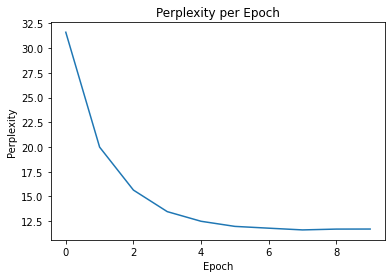

In [ ]:
plot_perplexity(dev_perplexities)

## Model Saving and Tracing

In [ ]:
torch.save(model.state_dict(), "attention_s11_new.pth")
#model.save("/content/")

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type EncoderDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Decoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type BahdanauAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/

In [23]:
model = make_model(len(SRC.vocab), len(TRG.vocab),
                   emb_size=256, hidden_size=256,
                   num_layers=1, dropout=0.2)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [24]:
#!cp /content/attention_s11_new.pth /content/drive/My\ Drive/EVA4/attention_s11_new.pth
!cp /content/drive/My\ Drive/EVA4/P2S11/* /content

In [ ]:
!cp /content/drive/My\ Drive/EVA4/RekogNizer/torchversionchange.py .

In [ ]:
torch.save(model.state_dict, "attention_s11.pth")

In [ ]:
#model.state_dict = torch.load("/content/attention_s11.pth")

In [ ]:
model.cuda()
model.load_state_dict(torch.load("/content/attention_s11_new.pth"))
#traced_model = torch.jit.trace(model.to("cpu"), torch.randn(1,3,512,512))

<All keys matched successfully>

In [ ]:
MAX_LENGTH = 25
model = model.to("cpu")
src = torch.LongTensor(1, MAX_LENGTH).random_(0, len(SRC.vocab)).to("cpu")
trg = torch.LongTensor(1, MAX_LENGTH).random_(0, len(TRG.vocab)).to("cpu")
src_t = model.src_embed(src).to("cpu")
trg_t = model.trg_embed(trg).to("cpu")
test_mask = torch.BoolTensor(1,1,MAX_LENGTH).to("cpu")
test_length = torch.LongTensor([MAX_LENGTH]).to("cpu")

torch.Size([1])

In [ ]:
traced_encoder = torch.jit.trace(model.encoder.to("cpu"), 
                                 (src_t.to("cpu"), 
                                  test_mask.to("cpu"), 
                                  test_length.to("cpu")))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: TracerWarning: Converting a tensor to a Python index might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: TracerWarning: Converting a tensor to a Python index might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
/usr/local/lib/python3.6/dist-packages/torch/tensor.py:746: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Te

In [ ]:
enc_hidden,enc_final = traced_encoder(src_t.to("cpu"), 
                                  test_mask.to("cpu"), 
                                  test_length.to("cpu"))
test_mask, test_length = torch.BoolTensor(1,1,MAX_LENGTH).to("cpu"), torch.LongTensor([MAX_LENGTH]).to("cpu")
# enc_hidden,enc_final = traced_encoder(input_embed.unsqueeze(0).to("cpu"), 
#                                       my_op.src_mask.to("cpu"), 
#                                       my_op.src_lengths.to("cpu"))

In [ ]:
traced_decoder = torch.jit.trace(model.decoder.to("cpu"), (trg_t, enc_hidden,enc_final, 
                                                           test_mask.to("cpu"), 
                                                           test_length.to("cpu"),torch.FloatTensor(1,1,256)))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: TracerWarning: Converting a tensor to a Python index might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
/usr/local/lib/python3.6/dist-packages/torch/tensor.py:746: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  warnings.warn("The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad "
/usr/local/lib/python3.6/dist-packages/torch/jit/__init__.py:1037: TracerWarning: Output nr 1.

In [ ]:
#traced_decoder = torch.jit.trace(model.decoder.to("cpu"), (trg_embed, enc_hidden,enc_final, my_op.src_mask.to("cpu"), my_op.trg_mask.to("cpu")))
model =model.to("cpu")
traced_src_embed = torch.jit.trace(model.src_embed, torch.LongTensor(1, MAX_LENGTH).random_(0, len(SRC.vocab)))
traced_trg_embed = torch.jit.trace(model.trg_embed, torch.LongTensor(1, MAX_LENGTH).random_(0, len(TRG.vocab)))
traced_generator = torch.jit.trace(model.generator, (torch.FloatTensor(1,256)) )

In [ ]:
traced_decoder.save("decoder.pt")
traced_encoder.save("encoder.pt")
traced_src_embed.save("embed_src.pt")
traced_trg_embed.save("embed_trg.pt")
traced_generator.save("generator.pt")

In [ ]:
traced_decoder = torch.jit.load("/content/decoder.pt")
traced_encoder  =torch.jit.load("/content/encoder.pt")
traced_src_embed = torch.jit.load("/content/embed_src.pt")
traced_trg_embed = torch.jit.load("/content/embed_trg.pt")
traced_generator = torch.jit.load("/content/generator.pt")

In [ ]:
!cp /content/en_de_translator.pickle /content/drive/My\ Drive/EVA4/P2S11
!cp /content/attention_s11_new.pth /content/drive/My\ Drive/EVA4/P2S11
!cp /content/encoder.pt /content/decoder.pt /content/embed_src.pt /content/embed_trg.pt /content/drive/My\ Drive/EVA4/P2S11

## Prediction and Evaluation

Once trained we can use the model to produce a set of translations. 

If we translate the whole validation set, we can use [SacreBLEU](https://github.com/mjpost/sacreBLEU) to get a [BLEU score](https://en.wikipedia.org/wiki/BLEU), which is the most common way to evaluate translations.

#### Important sidenote
Typically you would use SacreBLEU from the **command line** using the output file and original (possibly tokenized) development reference file. This will give you a nice version string that shows how the BLEU score was calculated; for example, if it was lowercased, if it was tokenized (and how), and what smoothing was used. If you want to learn more about how BLEU scores are (and should be) reported, check out [this paper](https://arxiv.org/abs/1804.08771).

However, right now our pre-processed data is only in memory, so we'll calculate the BLEU score right from this notebook for demonstration purposes.

We'll first test the raw BLEU function:

In [ ]:
gen_op.shape,gen_op.dtype

(torch.Size([1, 13002]), torch.float32)

In [ ]:
!cp /content/encoder.pt /content/generator.pt /content/embed_trg.pt /content/embed_src.pt /content/decoder.pt /content/drive/My\ Drive/EVA4/P2S11

In [ ]:
def greedy_decode_traced( traced_src_embed, traced_trg_embed, 
                         encoder, decoder, generator,
                         src, src_mask, 
                         src_lengths, max_len=100, sos_index=1, 
                         eos_index=None):
    """Greedily decode a sentence."""

    with torch.no_grad():
        #src_embed = model.src_embed(src)
        src_embed = traced_src_embed(src)
        print("#################### SRC Embedding receivd")
        encoder_hidden, encoder_final = encoder(src_embed, src_mask, src_lengths)
        prev_y = torch.ones(1, 1).fill_(sos_index).type_as(src)
        trg_mask = torch.ones_like(prev_y)

    output = []
    #attention_scores = []
    hidden = torch.zeros_like(torch.FloatTensor(1,1,256))

    for i in range(max_len):
        with torch.no_grad():
            #trg_embed = model.trg_embed(prev_y)
            trg_embed = traced_trg_embed(prev_y)
            #print("#################### TRG Embedding receivd")
            out, hidden, pre_output = decoder(trg_embed, 
                                              encoder_hidden, encoder_final, 
                                              src_mask,trg_mask,hidden)

            #   model.decode(
            #   encoder_hidden, encoder_final, src_mask,
            #   prev_y, trg_mask, hidden)

            # we predict from the pre-output layer, which is
            # a combination of Decoder state, prev emb, and context
            #prob = model.generator(pre_output[:, -1])
            prob = traced_generator(pre_output[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.data.item()
        output.append(next_word)
        prev_y = torch.ones(1, 1).type_as(src).fill_(next_word)
        #attention_scores.append(decoder.attention.alphas.cpu().numpy())
    print("Decoding completed",output,type(output))#, attention_scores)
    output = np.array(output)
        
    # cut off everything starting from </s> 
    #(only when eos_index provided)
    if eos_index is not None:
        first_eos = np.where(output==eos_index)[0]
        if len(first_eos) > 0:
            output = output[:first_eos[0]]      
    
    return output#, np.concatenate(attention_scores, axis=1)

In [ ]:
hypotheses = []
alphas = []  # save the last attention scores
for idx, batch in enumerate(valid_iter):
#   if(idx > 5):
#       break
  batch = rebatch(PAD_INDEX, batch)
  #pred, attention = 
  #torch.jit.script()
  pred = greedy_decode_traced(
    traced_src_embed, traced_trg_embed, 
    traced_encoder, traced_decoder, traced_generator,
    batch.src.to("cpu"), batch.src_mask.to("cpu"), 
    batch.src_lengths.to("cpu"), max_len=30,
    sos_index=TRG.vocab.stoi[SOS_TOKEN],
    eos_index=TRG.vocab.stoi[EOS_TOKEN])
  hypotheses.append(pred)
  alphas.append(attention)

In [ ]:
def print_batch_params(batch_elem):
    print("SRC Shape",batch_elem.src.shape, batch_elem.src_mask.shape, batch_elem.src_lengths.shape)
    print("TRG Shape",batch_elem.trg.shape, batch_elem.trg_mask.shape, batch_elem.trg_lengths.shape)

In [ ]:
def convert_to_target(hypotheses):
    hypotheses_ = [lookup_words(x, TRG.vocab) for x in hypotheses]
    print(hypotheses_[0])
    # finally, the SacreBLEU raw scorer requires string input, so we convert the lists to strings
    hypotheses_ = [" ".join(x) for x in hypotheses_]
    print(len(hypotheses_))
    print(hypotheses_[0])
    return hypotheses_

In [ ]:
de_text = "Warum gibt es immer unterschiedliche Antworten, wenn ich denselben Absatz auf Englisch schreibe, um ihn ins Deutsche zu übersetzen?"
token_de = tokenize_de(de_text)
idx = [ SRC.vocab.stoi[x] for x in token_de] 
my_src = (torch.LongTensor(idx), )

In [ ]:
my_op_batch = Batch((torch.LongTensor(idx).unsqueeze(0), torch.LongTensor([len(idx)])),
      (torch.LongTensor(idx).unsqueeze(0), torch.LongTensor([len(idx)])),
       pad_index=1)

pred = greedy_decode_traced(
    traced_src_embed, traced_trg_embed, 
    traced_encoder, traced_decoder, traced_generator,
    my_op_batch.src.to("cpu"), my_op_batch.src_mask.to("cpu"), 
    my_op_batch.src_lengths.to("cpu"), max_len=30,
    sos_index=TRG.vocab.stoi[SOS_TOKEN],
    eos_index=TRG.vocab.stoi[EOS_TOKEN])

#################### SRC Embedding receivd
Decoding completed [289, 8, 460, 104, 289, 23, 27, 17, 1479, 23, 3, 23, 3, 104, 289, 23, 3, 104, 6, 289, 23, 3, 8992, 23, 3, 23, 3, 104, 979, 23] <class 'list'>


In [ ]:
convert_to_target([pred])

['space', 'to', 'bring', 'into', 'space', '?', 'what', 'we', 'discover', '?']
1
space to bring into space ? what we discover ?


['space to bring into space ? what we discover ?']

## Pickling the VOCABs
These will be used during model deployment

In [ ]:
TRG_stoi_dict = { key:value_ for key,value_ in TRG.vocab.stoi.items()}
SRC_stoi_dict = { key:value_ for key,value_ in SRC.vocab.stoi.items()}
translator_vocab = { "TRG_stoi": TRG_stoi_dict, "TRG_itos":TRG.vocab.itos, "SRC_stoi": SRC_stoi_dict, "SRC_itos":SRC.vocab.itos}
import pickle
with open('en_de_translator.pickle','wb') as f:
    pickle.dump(translator_vocab, f)

In [ ]:
de_picked["TRG_stoi"]['when'] == translator_vocab["TRG_stoi"]['when']

True

In [ ]:
# this should result in a perfect BLEU of 100%
hypotheses = ["this is a test"]
references = ["this is a test"]
bleu = sacrebleu.raw_corpus_bleu(hypotheses, [references], .01).score
print(bleu)

100.00000000000004


In [ ]:
# here the BLEU score will be lower, because some n-grams won't match
hypotheses = ["this is a test"]
references = ["this is a fest"]
bleu = sacrebleu.raw_corpus_bleu(hypotheses, [references], .01).score
print(bleu)

22.360679774997894


In [ ]:
references = [" ".join(example.trg) for example in valid_data]
print(len(references))
print(references[0])
references[-2]

690
when i was 11 , i remember waking up one morning to the sound of joy in my house .


In [ ]:
hypotheses = []
alphas = []  # save the last attention scores
for batch in valid_iter:
  batch = rebatch(PAD_INDEX, batch)
  pred, attention = greedy_decode(
    model.cuda(), batch.src, batch.src_mask, batch.src_lengths, max_len=25,
    sos_index=TRG.vocab.stoi[SOS_TOKEN],
    eos_index=TRG.vocab.stoi[EOS_TOKEN])
  hypotheses.append(pred)
  alphas.append(attention)

/usr/local/lib/python3.6/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [ ]:
hypotheses = [lookup_words(x, TRG.vocab) for x in hypotheses]
hypotheses[0]
# finally, the SacreBLEU raw scorer requires string input, so we convert the lists to strings
hypotheses = [" ".join(x) for x in hypotheses]
print(len(hypotheses))
print(hypotheses[0])

690
when i was 11 years old , i was a <unk> in the morning of happiness .


In [ ]:
# finally, the SacreBLEU raw scorer requires string input, so we convert the lists to strings
hypotheses = [" ".join(x) for x in hypotheses]
print(len(hypotheses))
print(hypotheses[0])

690
thoroughly faster factory acknowledge likewise thrive brotherhood temperate undo edward pulls ! zone nobel 16th miller lip cognitive magazines substance powerless orville induced feed criminal


In [ ]:
# now we can compute the BLEU score!
bleu = sacrebleu.raw_corpus_bleu(hypotheses, [references], .01).score
print(bleu)

## Attention Visualization

We can also visualize the attention scores of the decoder.

In [ ]:
def plot_heatmap(src, trg, scores):

    fig, ax = plt.subplots()
    heatmap = ax.pcolor(scores, cmap='viridis')

    ax.set_xticklabels(trg, minor=False, rotation='vertical')
    ax.set_yticklabels(src, minor=False)

    # put the major ticks at the middle of each cell
    # and the x-ticks on top
    ax.xaxis.tick_top()
    ax.set_xticks(np.arange(scores.shape[1]) + 0.5, minor=False)
    ax.set_yticks(np.arange(scores.shape[0]) + 0.5, minor=False)
    ax.invert_yaxis()

    plt.colorbar(heatmap)
    plt.show()

src ['"', 'jetzt', 'kannst', 'du', 'auf', 'eine', 'richtige', 'schule', 'gehen', ',', '"', 'sagte', 'er', '.', '</s>']
ref ['"', 'you', 'can', 'go', 'to', 'a', 'real', 'school', 'now', ',', '"', 'he', 'said', '.', '</s>']
pred ['"', 'now', 'you', 'can', 'go', 'to', 'a', 'right', 'school', ',', '"', 'he', 'said', '.', '</s>']


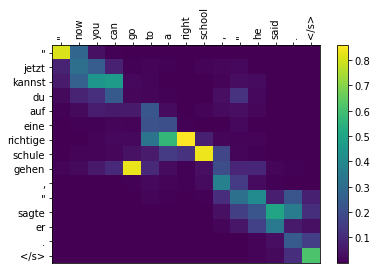

In [ ]:
# This plots a chosen sentence, for which we saved the attention scores above.
idx = 5
src = valid_data[idx].src + ["</s>"]
trg = valid_data[idx].trg + ["</s>"]
pred = hypotheses[idx].split() + ["</s>"]
pred_att = alphas[idx][0].T[:, :len(pred)]
print("src", src)
print("ref", trg)
print("pred", pred)
plot_heatmap(src, pred, pred_att)

## Saved model pushed to AWS S3

In [ ]:
!pip install boto3

     |████████████████████████████████| 133kB 10.6MB/s 
     |████████████████████████████████| 71kB 9.4MB/s 
     |████████████████████████████████| 6.7MB 23.7MB/s 
     |████████████████████████████████| 133kB 56.3MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
import os
import sys
import glob


In [ ]:
sys.path.append("/content/drive/My Drive/EVA4/RekogNizer")
sys.path.append("/content/drive/My Drive/EVA4/")

In [ ]:
glob.glob("./*pt")

['./generator.pt',
 './embed_src.pt',
 './decoder.pt',
 './encoder.pt',
 './embed_trg.pt']

In [ ]:
from RekogNizer import awsutils

for saved_model in glob.glob("./*pt"):
    awsutils.upload_model_to_s3('rekog-eva4s1',saved_model,os.path.basename(saved_model))

In [ ]:
import boto3
S3_BUCKET='rekog-eva4s1'
s3 = boto3.client('s3')
s3_res = boto3.resource('s3')
bucket = s3_res.Bucket(S3_BUCKET)

model_name='encoder.pt'
obj = s3.get_object(Bucket=S3_BUCKET, Key=model_name)
bytestream = io.BytesIO(obj['Body'].read() )
print("Loading Model {}".format(model_name))
traced_model = torch.jit.load(bytestream)
traced_model.eval()
#MODELS_DICT[key] = model
print( "Models {} Loaded".format(model_name))